## Imports

In [1]:
import functools

from clu import metric_writers
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import optax
import orbax.checkpoint as ocp
import h5py
import natsort
import tensorflow as tf
from scipy.ndimage import geometric_transform
from scipy.ndimage import gaussian_filter

from swirl_dynamics import templates
from swirl_dynamics.lib import diffusion as dfn_lib
from swirl_dynamics.lib import solvers as solver_lib
from swirl_dynamics.projects import probabilistic_diffusion as dfn

2024-02-26 10:04:50.309101: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Example - training both parameters

In [2]:
# Parameters for the computational task.

L = 4 # number of levels (even number)
s = 5 # leaf size
r = 3 # rank

# Discretization of Omega (n_eta * n_eta).
neta = (2**L)*s

# Number of sources/detectors (n_sc).
# Discretization of the domain of alpha in polar coordinates (n_theta * n_rho).
# For simplicity, these values are set equal (n_sc = n_theta = n_rho), facilitating computation.
nx = (2**L)*s

# Standard deviation for the Gaussian blur.
blur_sigma = 0.5

# Batch size.
BATCH_SIZE = 16

# Number of training datapoints.
NTRAIN = 18000

# Number of testing datapoints.
NTEST = 2000

# Total number
NTOTAL = NTRAIN + NTEST

In [3]:
#name = 'Data/traindata_smooth_sigma_0.04'
name = 'Data/traindata_shepp_logan'
#name = 'Data/traindata_L4s5_multifreq_ns10_square_10h_freq_2.5_5_10'
#name = 'Data/traindata_L4s5_multifreq_tri_10h_freq_2.5_5_10'
#name = 'Data/traindata_L4s5_multifreq_gaussian_10h_freq_2.5_5_10' # up to 14000 samples
#name = 'Data/traindata_L4s5_multifreq_blob_freq_2.5_5_10'

# Loading and preprocessing perturbation data (eta)
with h5py.File(f'{name}/eta.h5', 'r') as f:
    # Read eta data, apply Gaussian blur, and reshape
    eta_re = f[list(f.keys())[0]][:NTOTAL, :].reshape(-1, neta, neta)
    blur_fn = lambda x: gaussian_filter(x, sigma=blur_sigma)
    eta_re = np.stack([blur_fn(eta_re[i, :, :]) for i in range(NTOTAL)]).astype('float32')

# Loading and preprocessing scatter data (Lambda)
with h5py.File(f'{name}/scatter.h5', 'r') as f:
    keys = natsort.natsorted(f.keys())

    # Process real part of scatter data
    tmp1 = f[keys[3]][:NTOTAL, :].reshape((-1, nx, nx))
    tmp2 = f[keys[4]][:NTOTAL, :].reshape((-1, nx, nx))
    tmp3 = f[keys[5]][:NTOTAL, :].reshape((-1, nx, nx))
    scatter_re = np.stack((tmp1, tmp2, tmp3), axis=-1)

    # Process imaginary part of scatter data
    tmp1 = f[keys[0]][:NTOTAL, :].reshape((-1, nx, nx))
    tmp2 = f[keys[1]][:NTOTAL, :].reshape((-1, nx, nx))
    tmp3 = f[keys[2]][:NTOTAL, :].reshape((-1, nx, nx))
    scatter_im = np.stack((tmp1, tmp2, tmp3), axis=-1)

    # Combine real and imaginary parts
    scatter_ = np.stack((scatter_re, scatter_im), axis=1).astype('float32')

# Clean up temporary variables to free memory
del scatter_re, scatter_im, tmp1, tmp2, tmp3

In [4]:
scatter = np.swapaxes(np.swapaxes(np.swapaxes(scatter_,1,2),2,3),3,4)
assert scatter.shape == (NTOTAL, 80, 80, 3, 2)

In [5]:
scatter_train = np.reshape(scatter[:NTRAIN,:,:],(NTRAIN,80,80,6))
eta_re_train = np.array([eta_re[:NTRAIN,:,:]])
eta_re_train = np.swapaxes(np.swapaxes(np.swapaxes(eta_re_train,0,1),1,2),2,3)
#scatter_eta_re = np.concatenate((scatter,eta_re),axis=-1)
assert eta_re_train.shape == (NTRAIN, 80, 80, 1)
assert scatter_train.shape == (NTRAIN, 80, 80, 6)

In [6]:
scatter_eta_re_train = np.concatenate((scatter_train,eta_re_train),axis=-1)
assert scatter_eta_re_train.shape == (NTRAIN, 80, 80, 7)

In [7]:
scatter_eta_re_train_norm = (scatter_eta_re_train- np.mean(scatter_eta_re_train,axis=0))

In [8]:
assert scatter_eta_re_train_norm.shape == (NTRAIN, 80, 80, 7)

In [10]:
# To avoid tf to use GPU memory
tf.config.set_visible_devices([], device_type='GPU')

batch_size = 16
dict_data = {"x": scatter_eta_re_train_norm}
dataset = tf.data.Dataset.from_tensor_slices(dict_data)
dataset = dataset.repeat()
dataset = dataset.batch(batch_size)
dataset = dataset.prefetch(tf.data.AUTOTUNE)
dataset = eval_dataloader = dataset.as_numpy_iterator()

2024-02-26 10:08:31.001797: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [9]:
data_std = np.std(scatter_eta_re_train_norm)

In [11]:
print(data_std)

0.15562037


### Architecture

Next let's define the U-Net backbone. The "Preconditioning" is merely to ensure that the inputs and outputs of the network are roughly standardized (for more details, see Appendix B.6. in [this paper](https://arxiv.org/abs/2206.00364)).

In [12]:
denoiser_model = dfn_lib.PreconditionedDenoiser(
    out_channels=1,
    num_channels=(64, 128),
    downsample_ratio=(2, 2),
    num_blocks=4,
    noise_embed_dim=128,
    padding="SAME",
    use_attention=True,
    use_position_encoding=True,
    num_heads=8,
    sigma_data=data_std,
)

In [13]:
diffusion_scheme = dfn_lib.Diffusion.create_variance_exploding(
    sigma=dfn_lib.tangent_noise_schedule(),
    data_std=data_std,
)

model = dfn.DenoisingModel(
    # `input_shape` must agree with the expected sample shape (without the batch
    # dimension), which in this case is simply the dimensions of a single MNIST
    # sample.
    input_shape=(80, 80, 7),
    denoiser=denoiser_model,
    noise_sampling=dfn_lib.log_uniform_sampling(
        diffusion_scheme, clip_min=1e-4, uniform_grid=True,
    ),
    noise_weighting=dfn_lib.edm_weighting(data_std=data_std),
)

In [14]:
num_train_steps = 100000  #@param
workdir = "/tmp/diffusion_joint_traindata_shepp_logan"  #@param
initial_lr = 0.0  #@param
peak_lr = 1e-4  #@param
warmup_steps = 1000  #@param
end_lr = 1e-6  #@param
ema_decay = 0.999  #@param
ckpt_interval = 1000  #@param
max_ckpt_to_keep = 5  #@param

### Training

For diffusion model training, the above-defined U-Net backbone serves as a denoiser, which takes as input a batch of (isotropic Gaussian noise) corrupted samples and outputs its best guess for what the uncorrupted image would be.

Besides the backbone architecture, we also need to specify how to sample the noise levels (i.e. standard deviations) used to corrupt the samples and the weighting for each noise level in the loss function (for other options and configurations, see [`swirl_dynamics.lib.diffusion.diffusion`](https://github.com/google-research/swirl-dynamics/blob/main/swirl_dynamics/lib/diffusion/diffusion.py)):

In [15]:
# NOTE: use `trainers.DistributedDenoisingTrainer` for multi-device
# training with data parallelism.
trainer = dfn.DenoisingTrainer(
    model=model,
    rng=jax.random.PRNGKey(888),
    optimizer=optax.adam(
        learning_rate=optax.warmup_cosine_decay_schedule(
            init_value=initial_lr,
            peak_value=peak_lr,
            warmup_steps=warmup_steps,
            decay_steps=num_train_steps,
            end_value=end_lr,
        ),
    ),
    # We keep track of an exponential moving average of the model parameters
    # over training steps. This alleviates the "color-shift" problems known to
    # exist in the diffusion models.
    ema_decay=ema_decay,
)

In [16]:
templates.run_train(
    train_dataloader=dataset,
    trainer=trainer,
    workdir=workdir,
    total_train_steps=num_train_steps,
    metric_writer=metric_writers.create_default_writer(
        workdir, asynchronous=False
    ),
    metric_aggregation_steps=100,
    eval_dataloader=eval_dataloader,
    eval_every_steps = 1000,
    num_batches_per_eval = 2,
    callbacks=(
        # This callback displays the training progress in a tqdm bar
        templates.TqdmProgressBar(
            total_train_steps=num_train_steps,
            train_monitors=("train_loss",),
        ),
        # This callback saves model checkpoint periodically
        templates.TrainStateCheckpoint(
            base_dir=workdir,
            options=ocp.CheckpointManagerOptions(
                save_interval_steps=ckpt_interval, max_to_keep=max_ckpt_to_keep
            ),
        ),
    ),
)

  0%|          | 0/100000 [00:00<?, ?step/s]

### Inference

#### trainers generation

The trained denoiser may be used to generate trainers samples.

First, let's try to restore the model from checkpoint.

In [15]:
# Restore train state from checkpoint. By default, the move recently saved
# checkpoint is restored. Alternatively, one can directly use
# `trainer.train_state` if continuing from the training section above.
trained_state = dfn.DenoisingModelTrainState.restore_from_orbax_ckpt(
    f"{workdir}/checkpoints", step=None
)
# Construct the inference function
denoise_fn = dfn.DenoisingTrainer.inference_fn_from_state_dict(
    trained_state, use_ema=True, denoiser=denoiser_model
)

Diffusion samples are generated by plugging the trained denoising function in a stochastic differential equation (parametrized by the diffusion scheme) and solving it backwards in time.

In [16]:
sampler = dfn_lib.SdeSampler(
    input_shape=(80, 80, 7),
    integrator=solver_lib.EulerMaruyama(),
    tspan=dfn_lib.edm_noise_decay(
        diffusion_scheme, rho=7, num_steps=256, end_sigma=1e-3,
    ),
    scheme=diffusion_scheme,
    denoise_fn=denoise_fn,
    guidance_transforms=(),
    apply_denoise_at_end=True,
    return_full_paths=False,  # Set to `True` if the full sampling paths are needed
)

In [17]:
# Optional: JIT compile the generate function so that it runs faster if
# repeatedly called.
generate = jax.jit(sampler.generate, static_argnames=('num_samples',))

In [38]:
num_samples = 20
samples = generate(
    rng=jax.random.PRNGKey(8888), num_samples=num_samples
)

In [46]:
samples.shape

(20, 80, 80, 7)

In [47]:
samples_denorm = np.zeros((num_samples, 80, 80, 7))
for i in range(num_samples):
    samples_denorm[i,:,:,:] = samples[i,:,:,:] + np.mean(scatter_eta_re_train,axis=0)

Visualize the samples.

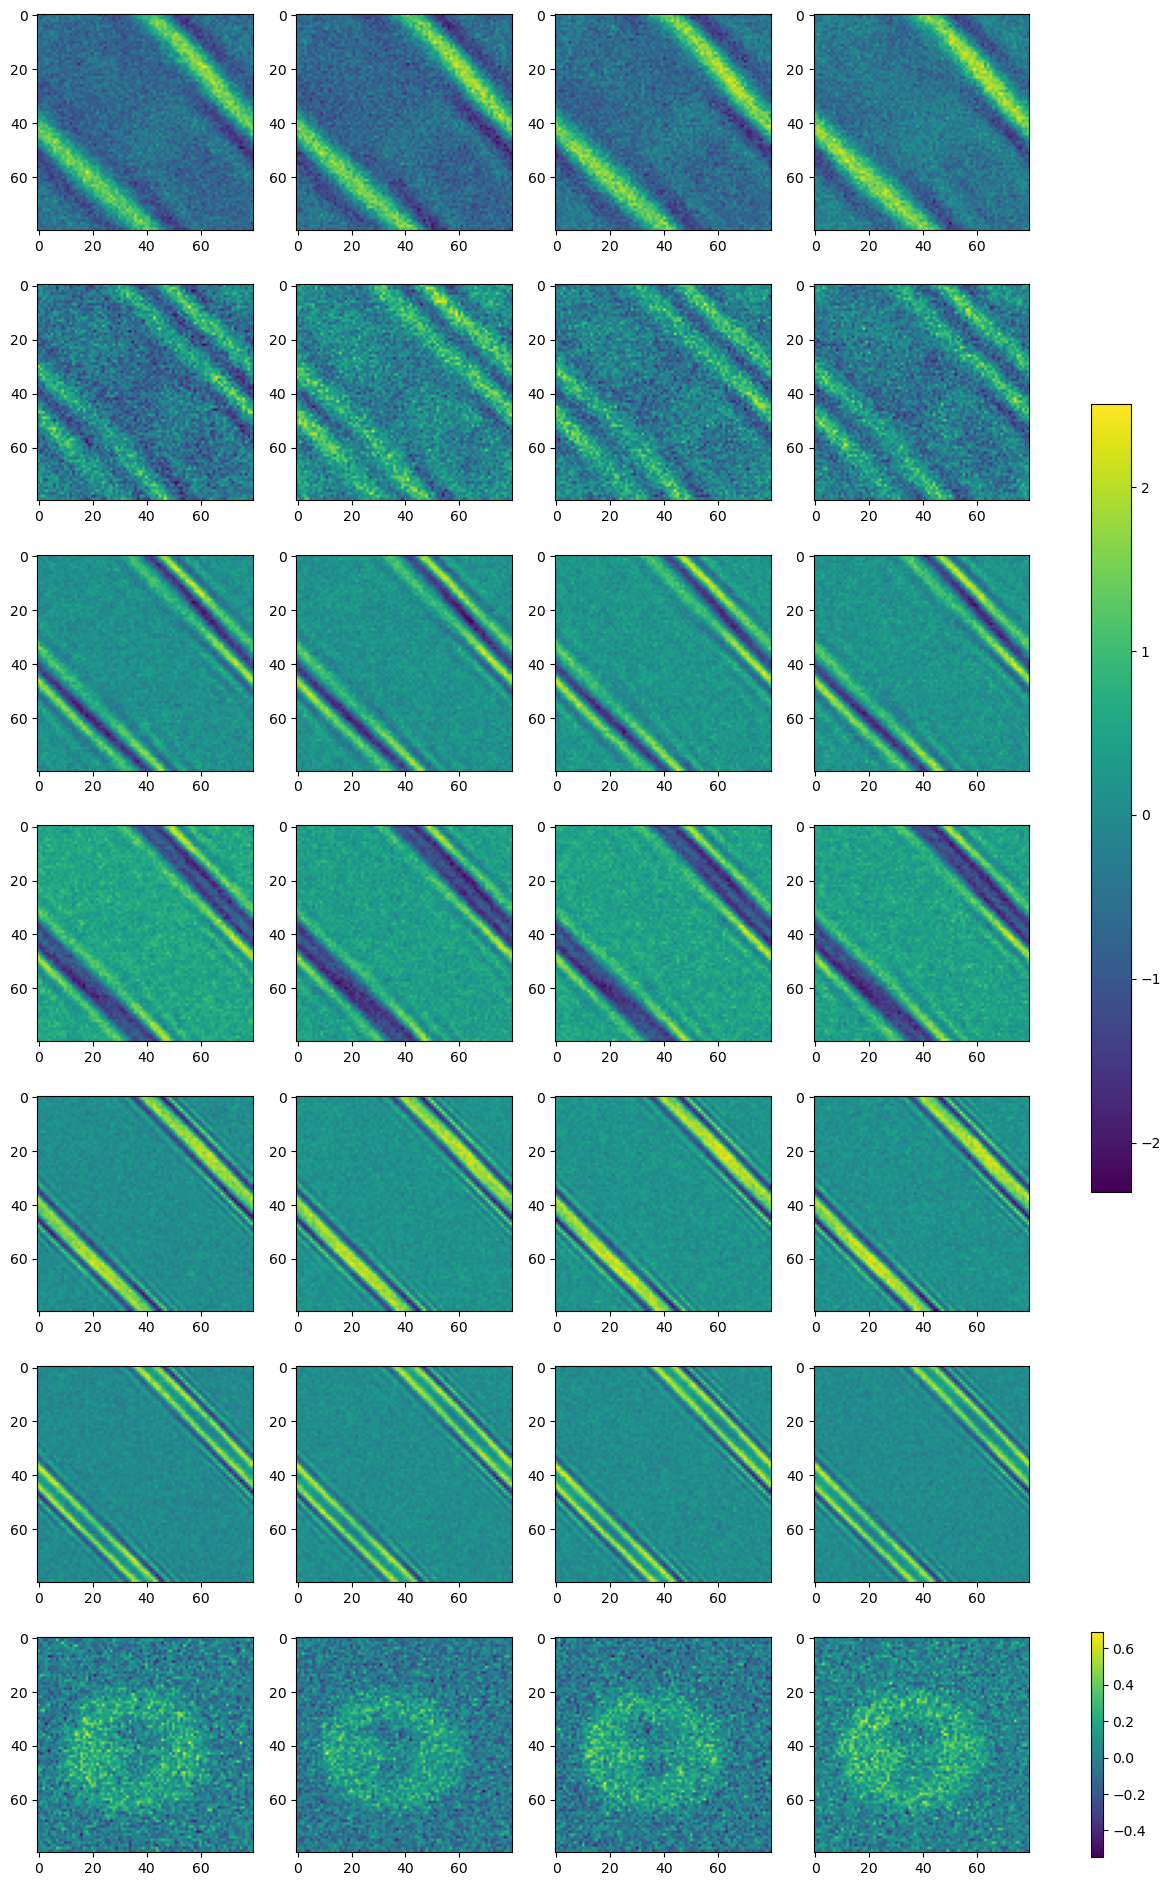

In [37]:
# Plot generated samples
#vmin, vmax = -3, 3

# Plot generated samples #eta
fig, ax = plt.subplots(7, 4, figsize=(16, 24))
for j in range(6):
    for i in range(4):
        im = ax[j,i].imshow(samples_denorm[i, :, :, j])#, vmin=vmin, vmax=vmax)
fig.colorbar(im, ax=ax[:6,:], shrink=0.5, location="right")
for i in range(4):
    im = ax[6,i].imshow(samples_denorm[i, :, :, 6])
fig.colorbar(im, ax=ax[6,:], location="right")
#plt.tight_layout()
plt.savefig('joint_shepp_logan_freq_2.5_5_10.png')
#plt.show()

## Metrics

We compute the Wasserstein distance.

In [39]:
import ott
from ott import problems
from ott.geometry import costs, pointcloud
from ott.solvers import linear
from ott.problems.linear import linear_problem
from ott.solvers.linear import acceleration, sinkhorn
from ott.tools.sinkhorn_divergence import sinkhorn_divergence

We get the test samples.

In [48]:
scatter_test = np.reshape(scatter[NTRAIN:,:,:],(NTEST,80,80,6))
eta_re_test = np.array([eta_re[NTRAIN:,:,:]])
eta_re_test = np.swapaxes(np.swapaxes(np.swapaxes(eta_re_test,0,1),1,2),2,3)
scatter_eta_re_test = np.concatenate((scatter_test,eta_re_test),axis=-1)

In [49]:
assert scatter_eta_re_test.shape == (NTEST, 80, 80, 7)

In [50]:
batch_size_testing = 20
dict_data_test = {}
dict_data_test["truth"] = {"scatter-eta": scatter_eta_re_test}
dataset_test = tf.data.Dataset.from_tensor_slices(dict_data_test)
dataset_test = dataset_test.repeat()
dataset_test = dataset_test.batch(batch_size_testing)
dataset_test = dataset_test.prefetch(tf.data.AUTOTUNE)
dataset_test = dataset_test.as_numpy_iterator()
test_batch_eta = next(iter(dataset_test))["truth"]

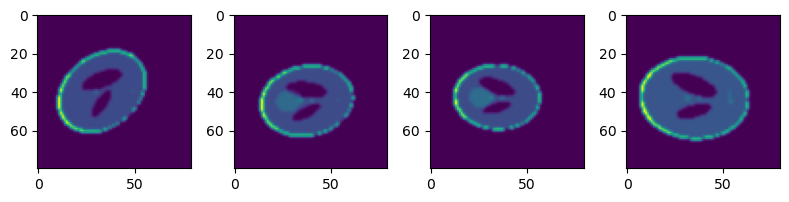

In [51]:
# Plot testing samples
#vmin, vmax = -3, 3

# Plot generated samples #eta
fig, ax = plt.subplots(1, 4, figsize=(8, 2))
for i in range(4):
    im = ax[i].imshow(test_batch_eta["scatter-eta"][i, :, :, 6])#, vmin=vmin, vmax=vmax)

plt.tight_layout()
plt.show()

In [52]:
samples_denorm[:,:,:,6].shape

(20, 80, 80)

In [63]:
samples_theta = np.zeros((10,80*80))
samples_test = np.zeros((batch_size_testing,80*80))
samples_training = np.zeros((NTRAIN,80*80))
samples_theta[:,:] = samples_denorm[:10,:,:,6].reshape(10,80*80)
samples_test[:,:] = test_batch_eta["scatter-eta"][:,:,:,6].reshape(batch_size_testing,80*80)
samples_training[:,:] = scatter_eta_re_train[:,:,:,6].reshape(NTRAIN,80*80)

In [64]:
geom_1 = pointcloud.PointCloud(samples_training, samples_test, cost_fn=costs.Euclidean())

In [65]:
# Define a linear problem with that cost structure.
ot_prob = linear_problem.LinearProblem(geom_1)
# Create a Sinkhorn solver
solver = sinkhorn.Sinkhorn()
# Solve OT problem
ot = solver(ot_prob)
# The out object contains many things, among which the regularized OT cost
print(
    " Sinkhorn has converged: ",
    ot.converged,
    "\n",
    "Error upon last iteration: ",
    ot.errors[(ot.errors > -1)][-1],
    "\n",
    "Sinkhorn required ",
    jnp.sum(ot.errors > -1),
    " iterations to converge. \n",
    "Entropy regularized OT cost: ",
    ot.reg_ot_cost,
    "\n",
    "OT cost (without entropy): ",
    jnp.sum(ot.matrix * ot.geom.cost_matrix),
)

 Sinkhorn has converged:  True 
 Error upon last iteration:  0.0002917834 
 Sinkhorn required  2  iterations to converge. 
 Entropy regularized OT cost:  8.166883 
 OT cost (without entropy):  7.306817


In [66]:
geom_2 = pointcloud.PointCloud(samples_theta, samples_test, cost_fn=costs.Euclidean())

In [67]:
# Define a linear problem with that cost structure.
ot_prob = linear_problem.LinearProblem(geom_2)
# Create a Sinkhorn solver
solver = sinkhorn.Sinkhorn()
# Solve OT problem
ot = solver(ot_prob)
# The out object contains many things, among which the regularized OT cost
print(
    " Sinkhorn has converged: ",
    ot.converged,
    "\n",
    "Error upon last iteration: ",
    ot.errors[(ot.errors > -1)][-1],
    "\n",
    "Sinkhorn required ",
    jnp.sum(ot.errors > -1),
    " iterations to converge. \n",
    "Entropy regularized OT cost: ",
    ot.reg_ot_cost,
    "\n",
    "OT cost (without entropy): ",
    jnp.sum(ot.matrix * ot.geom.cost_matrix),
)

 Sinkhorn has converged:  True 
 Error upon last iteration:  7.450579e-08 
 Sinkhorn required  1  iterations to converge. 
 Entropy regularized OT cost:  13.389279 
 OT cost (without entropy):  13.384881
